# DLthon - 길찾은 오리들
## Base Settings

In [3]:
# importing the libraries
import keras, tensorflow as tf
import pathlib
from keras import layers

# keras.mixed_precision.set_global_policy('mixed_float16')

# importing the modules
import models_base, models_top, utils

In [4]:
# loading the dataset
train_dataset, val_dataset, test_dataset = utils.load_datasets("data_no_aug")

Found 319 files belonging to 6 classes.
Found 39 files belonging to 6 classes.
Found 40 files belonging to 6 classes.




## Basemodel

여기에 ResNet50 결과 입력

## EfficientNetV2L + Top3
### Designing the Model

In [5]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# designing the model

def eV2L_top3(): # this can be adjusted to be hyper-tunable
    inputs = keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = models_base.EV2L((224, 224, 3))(inputs, training=False)
    x = models_top.top3(x)
    outputs = layers.Dense(6, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    
    model.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['accuracy'])
    
    return model

In [6]:
eV2L_top3_history = eV2L_top3().fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[
        utils.callback_savemodel('eV2L_top3.keras'),
        utils.callback_earlystop(30)
    ],
)

Epoch 1/200


I0000 00:00:1737282654.523215    4406 service.cc:148] XLA service 0x7fe330002790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737282654.523653    4406 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-01-19 19:30:55.555704: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737282658.877219    4406 cuda_dnn.cc:529] Loaded cuDNN version 90600
2025-01-19 19:31:05.109142: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_47294_0', 428 bytes spill stores, 684 bytes spill loads

2025-01-19 19:31:05.262818: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_47294', 22

4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.2126 - f1_score: 0.1561 - loss: 1.8328

2025-01-19 19:31:35.425552: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_47294', 252 bytes spill stores, 252 bytes spill loads

2025-01-19 19:31:35.564122: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_47730', 460 bytes spill stores, 460 bytes spill loads

2025-01-19 19:31:35.631546: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_47728', 4 bytes spill stores, 4 bytes spill loads

2025-01-19 19:31:35.640371: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_47728', 72 bytes spill stores, 72 bytes spill loads

2025-01-19 19:31:35.702490: I external/local_xla/xla/s

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2102 - f1_score: 0.1629 - loss: 1.8346   

2025-01-19 19:32:08.121367: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8413', 8 bytes spill stores, 8 bytes spill loads

2025-01-19 19:32:08.721423: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8427', 12 bytes spill stores, 12 bytes spill loads

2025-01-19 19:32:08.740859: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8413', 252 bytes spill stores, 252 bytes spill loads

2025-01-19 19:32:08.894087: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8413_0', 8 bytes spill stores, 8 bytes spill loads



5/5 ━━━━━━━━━━━━━━━━━━━━ 108s 13s/step - accuracy: 0.2086 - f1_score: 0.1674 - loss: 1.8358 - val_accuracy: 0.1538 - val_f1_score: 0.0465 - val_loss: 1.7808
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 728ms/step - accuracy: 0.2154 - f1_score: 0.1806 - loss: 1.7395 - val_accuracy: 0.5641 - val_f1_score: 0.5156 - val_loss: 1.6254
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.3340 - f1_score: 0.3207 - loss: 1.6040 - val_accuracy: 0.3077 - val_f1_score: 0.2450 - val_loss: 1.6521
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.2679 - f1_score: 0.2553 - loss: 1.6296 - val_accuracy: 0.3846 - val_f1_score: 0.2963 - val_loss: 1.5090
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.4302 - f1_score: 0.3963 - loss: 1.4328 - val_accuracy: 0.4615 - val_f1_score: 0.3850 - val_loss: 1.3710
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.5243 - f1_score: 0.5049 - loss: 1.2589 - val_accuracy: 0.3333 - val_f1_score: 0.2678 - val_loss: 2.242

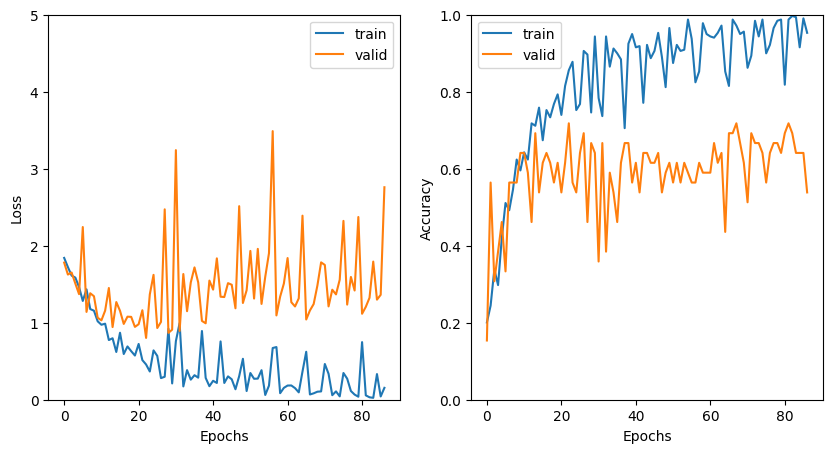

In [13]:
utils.plot_history(eV2L_top3_history)

In [ ]:
eV2L_top1_best = keras.models.load_model('eV2L_top2.keras')
test_loss, test_acc = eV2L_top1_best.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.2f}%, Test loss: {test_loss:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.8000 - loss: 1.0672


ValueError: not enough values to unpack (expected 3, got 2)

## Second Trial: MobileNetV2 + Top1

In [ ]:
def mV2_top1():
    inputs = keras.Input(shape=(224, 224, 3))
    x = models_base.MV2()(inputs, training=False)
    x = models_top.top1(x)
    outputs = layers.Dense(6, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    model.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['accuracy'])

    return model

mV2_top1_history = mV2_top1().fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[
        utils.callback_savemodel('mV2_top1.keras'),
        utils.callback_earlystop(80)
    ],
)

In [ ]:
utils.plot_history(mV2_top1_history)

In [ ]:
mV2_top1_best = keras.models.load_model('mV2_top1.keras')
test_loss, test_acc = mV2_top1_best.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.2f}%, Test loss: {test_loss:.2f}")